In [1]:
from csv import DictReader

with open('_data/properties_master.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows = [r for r in reader]
csv_file.close()

In [2]:
properties_to_use = [
    'properties.cetane_number.value',
    'properties.ysi_unified.value'
]

samples = []
for row in rows:
    use = True
    for prop in properties_to_use:
        if row[prop] == '-':
            use = False
            break
    if use:
        samples.append(row)

print(len(samples))

150


In [3]:
import numpy as np

data_cn = np.array([float(s['properties.cetane_number.value']) for s in samples]).reshape(-1, 1)

data_ysi = np.array([float(s['properties.ysi_unified.value']) for s in samples]).reshape(-1, 1)

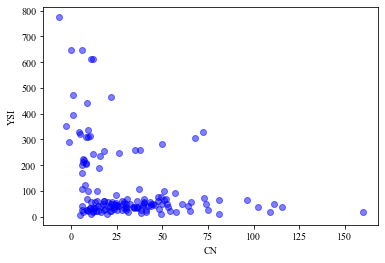

In [4]:
from matplotlib import pyplot as plt

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('CN')
plt.ylabel('YSI')
plt.scatter(data_cn, data_ysi, color='blue', alpha=0.5)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from ecnet.datasets import QSPRDataset

smiles = [s['canonical_smiles'] for s in samples]
smiles_train, smiles_test, cn_train, cn_test, ysi_train, ysi_test = train_test_split(smiles, data_cn, data_ysi, test_size=0.25, random_state=42)

ds_cn_train = QSPRDataset(smiles_train, cn_train, backend='alvadesc')
ds_cn_test = QSPRDataset(smiles_test, cn_test, backend='alvadesc')

ds_ysi_train = QSPRDataset(smiles_train, ysi_train, backend='alvadesc')
ds_ysi_test = QSPRDataset(smiles_test, ysi_test, backend='alvadesc')

In [6]:
from sklearn.decomposition import PCA
import torch

pca_cn = PCA()
pca_ysi = PCA()

pca_cn.fit(ds_cn_train.desc_vals.detach().numpy())
pca_ysi.fit(ds_ysi_train.desc_vals.detach().numpy())

ds_cn_train.desc_vals = torch.tensor(pca_cn.transform(ds_cn_train.desc_vals.detach().numpy())).type(torch.float32)
ds_cn_train.target_vals = ds_cn_train.target_vals.type(torch.float32)
ds_cn_test.desc_vals = torch.tensor(pca_cn.transform(ds_cn_test.desc_vals.detach().numpy())).type(torch.float32)
ds_cn_test.target_vals = ds_cn_test.target_vals.type(torch.float32)

ds_ysi_train.desc_vals = torch.tensor(pca_ysi.transform(ds_ysi_train.desc_vals.detach().numpy())).type(torch.float32)
ds_ysi_train.target_vals = ds_ysi_train.target_vals.type(torch.float32)
ds_ysi_test.desc_vals = torch.tensor(pca_ysi.transform(ds_ysi_test.desc_vals.detach().numpy())).type(torch.float32)
ds_ysi_test.target_vals = ds_ysi_test.target_vals.type(torch.float32)

print(ds_cn_train.desc_vals.shape, ds_cn_test.desc_vals.shape)
print(ds_ysi_train.desc_vals.shape, ds_ysi_test.desc_vals.shape)
print(ds_cn_train.desc_vals.type())

torch.Size([112, 112]) torch.Size([38, 112])
torch.Size([112, 112]) torch.Size([38, 112])
torch.FloatTensor


In [7]:
from ecnet import ECNet

print('Cetane number...')
model_cn = ECNet(ds_cn_train.desc_vals.shape[1], ds_cn_train.target_vals.shape[1], 1024, 1)
train_loss_cn, valid_loss_cn = model_cn.fit(dataset=ds_cn_train, epochs=500, valid_size=0.25, random_state=42, patience=32, verbose=10, lr=0.001)

print('Yield sooting index...')
model_ysi = ECNet(ds_ysi_train.desc_vals.shape[1], ds_ysi_train.target_vals.shape[1], 1024, 1)
train_loss_ysi, valid_loss_ysi = model_ysi.fit(dataset=ds_ysi_train, epochs=500, valid_size=0.25, random_state=42, patience=32, verbose=10, lr=0.001)

Cetane number...
Epoch: 0 | Train loss: 13917.697521391368 | Valid loss: 9223372036854775807
Epoch: 10 | Train loss: 687.4206310453869 | Valid loss: 2174.428955078125
Epoch: 20 | Train loss: 287.4075746082124 | Valid loss: 1232.448974609375
Epoch: 30 | Train loss: 148.18676685151598 | Valid loss: 413.7607116699219
Epoch: 40 | Train loss: 84.08352951776413 | Valid loss: 291.92254638671875
Epoch: 50 | Train loss: 46.356954847063335 | Valid loss: 286.0257263183594
Epoch: 60 | Train loss: 23.27905291602725 | Valid loss: 223.695556640625
Epoch: 70 | Train loss: 11.624214717320033 | Valid loss: 211.17884826660156
Epoch: 80 | Train loss: 6.252362557819912 | Valid loss: 194.19834899902344
Epoch: 90 | Train loss: 3.580937771570115 | Valid loss: 171.2144012451172
Epoch: 100 | Train loss: 2.4571126302083335 | Valid loss: 162.0472869873047
Epoch: 110 | Train loss: 1.521861473719279 | Valid loss: 150.72291564941406
Epoch: 120 | Train loss: 1.2826240687143236 | Valid loss: 138.4322967529297
Epoch: 1

In [8]:
from sklearn.metrics import r2_score, median_absolute_error

pred_train_cn = model_cn(ds_cn_train.desc_vals).detach().numpy()
pred_test_cn = model_cn(ds_cn_test.desc_vals).detach().numpy()

pred_train_ysi = model_ysi(ds_ysi_train.desc_vals).detach().numpy()
pred_test_ysi = model_ysi(ds_ysi_test.desc_vals).detach().numpy()

mae_train_cn = median_absolute_error(ds_cn_train.target_vals.detach().numpy(), pred_train_cn)
mae_test_cn = median_absolute_error(ds_cn_test.target_vals.detach().numpy(), pred_test_cn)
r2_train_cn = r2_score(ds_cn_train.target_vals.detach().numpy(), pred_train_cn)
r2_test_cn = r2_score(ds_cn_test.target_vals.detach().numpy(), pred_test_cn)

mae_train_ysi = median_absolute_error(ds_ysi_train.target_vals.detach().numpy(), pred_train_ysi)
mae_test_ysi = median_absolute_error(ds_ysi_test.target_vals.detach().numpy(), pred_test_ysi)
r2_train_ysi = r2_score(ds_ysi_train.target_vals.detach().numpy(), pred_train_ysi)
r2_test_ysi = r2_score(ds_ysi_test.target_vals.detach().numpy(), pred_test_ysi)

print(f'CN train: {r2_train_cn} | {mae_train_cn}')
print(f'CN test: {r2_test_cn} | {mae_test_cn}')
print(f'YSI train: {r2_train_ysi} | {mae_train_ysi}')
print(f'YSI test: {r2_test_ysi} | {mae_test_ysi}')

CN train: 0.9497353766436205 | 0.15843486785888672
CN test: 0.43211420616641927 | 5.108871936798096
YSI train: 0.9880729291294797 | 2.8419952392578125
YSI test: 0.9219774171759071 | 7.295771598815918


In [ ]:
from matplotlib import pyplot as plt

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental CN')
plt.ylabel('Predicted CN')
plt.scatter()